# PEFT Techniques on T5-Small for IMDB Sentiment Classification  
### Adapters

This notebook evaluates **Adapter**-based parameter-efficient fine-tuning on the IMDB dataset using T5-small. It includes dataset preprocessing, adapter configuration, training, and evaluation across different reduction factors.


## 1. Setup and Imports

In [30]:
import subprocess
import sys

result = subprocess.run([sys.executable, '-m', 'pip', 'list'], 
                       capture_output=True, text=True)

print("ML/NLP Related Packages:\n")
keywords = ['transformers', 'torch', 'tensorflow', 'datasets', 'tokenizers', 
            'adapters', 'accelerate', 'evaluate', 'sentencepiece', 'sacremoses']

for line in result.stdout.split('\n'):
    if any(keyword in line.lower() for keyword in keywords):
        print(line)

ML/NLP Related Packages:

accelerate                1.12.0
adapters                  1.2.0
datasets                  4.4.1
evaluate                  0.4.6
tokenizers                0.21.4
torch                     2.9.1
transformers              4.51.3


In [31]:
import gc
import torch
import matplotlib.pyplot as plt
import datasets
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback,
)
import evaluate

# For adapter-transformers, the import stays the same
from adapters import AutoAdapterModel, AdapterConfig

## 2. Load and Preprocess IMDB Dataset

We load IMDB, split into train/validation/test, and tokenize text for T5. The original labels are `0` (negative) and `1` (positive).
Since T5 is a sequence-to-sequence model, we convert labels to the strings `"negative"` and `"positive"` and train the model to generate these label tokens.

In [32]:
# load the IMDB splits: train, test and unsupervised (we do not use unsupervised)
dataset = load_dataset("imdb", split=['train', 'test', 'unsupervised'])

# wrap into a DatasetDict for convenience
dataset = datasets.DatasetDict(
    {
        "train" : dataset[0],
        "test" : dataset[1],
        "unsupervised" : dataset[2]
    }
)

# split the original training set into train and validation
dataset["train"], dataset["validation"] = dataset["train"].train_test_split(test_size=0.2, seed=42).values()

## 3. Tokenization

In [33]:
# load T5-small tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-small")

# if pad token is missing, use eos token as pad
if tokenizer.pad_token_id is None:
  tokenizer.pad_token_id = tokenizer.eos_token_id



In [34]:
# tokenize a batch of IMDB examples for T5.
def tokenize(batch):

  # tokenize input texts
  model_inputs = tokenizer(batch["text"], padding=False, truncation=True)

  # convert numeric labels to text labels
  label = ["negative" if label == 0 else "positive" for label in batch["label"]]

  # tokenize labels as targets
  labels = tokenizer(text_target=label, truncation=True)
  model_inputs["labels"] = labels["input_ids"]

  return model_inputs

In [35]:
# apply tokenization to all splits
tokenized_ds = dataset.map(tokenize, batched=True, num_proc=4, remove_columns=dataset["train"].column_names)

In [36]:
train_ds = tokenized_ds["train"] # train dataset
eval_ds = tokenized_ds["validation"]
test_ds = tokenized_ds["test"]


## 4. Data collator and evaluation metric

We use `DataCollatorForSeq2Seq` to handle padding and label shifting for T5, and `accuracy` from `evaluate` as our metric.


In [37]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=None)

In [38]:
from evaluate import load

accuracy = load("accuracy")


# compute accuracy from generated predictions and labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    # Replace -100 so labels can be decoded
    labels = [[token if token != -100 else tokenizer.pad_token_id for token in label]
              for label in labels ]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    pred_labels = [1 if pred.strip() == "positive" else 0 for pred in decoded_preds]
    true_labels = [1 if lab.strip() == "positive" else 0 for lab in decoded_labels]
    return accuracy.compute(predictions=pred_labels, references=true_labels)



## 5. Adapter configuration and Trainer helper
The function below loads a `t5-small` model with adapter support, adds a new adapter with a given reduction factor, activates and enables training for that adapter and constructs a `Seq2SeqTrainer` configured for our IMDB task.

In [10]:

def get_trainer_and_adapter_model(r):


    # Load base model with adapter support
    model = AutoAdapterModel.from_pretrained("t5-small")

    # Add, activate, and train the adapter
    adapter_name = f"imdb_adapter_r{r}"
    adapter_config = AdapterConfig.load("houlsby", reduction_factor=r)
    model.add_adapter(adapter_name, config=adapter_config)
    model.train_adapter(adapter_name) # freeze model parametes and unfreeze only adapter parameters, name is kind of a misnomer
    model.set_active_adapters(adapter_name)

    print(model.adapter_summary())

    # Update data collator with the model for correct label shifting and padding
    data_collator.model = model
    batch_size = 128
    # Training arguments
    training_args = Seq2SeqTrainingArguments(
      output_dir=f"t5_adapter_imdb_r{r}",
        
      learning_rate=5e-3,
      per_device_train_batch_size=batch_size,
      gradient_accumulation_steps=4, #accumulate gradients over 4 steps, effective batch size = batch_size * 4
      gradient_checkpointing_kwargs={"use_reentrant": False},
      per_device_eval_batch_size=batch_size,
      fp16=True, #half precision training
      num_train_epochs=5,
      # logging_steps=50, #check training process
      logging_strategy="epoch",
      label_names=["labels"],
      gradient_checkpointing=True, #new #saves memory by recomputing gradients during back prop
      save_strategy="epoch", #checkpoints
      eval_strategy="epoch",
      # save_steps=50,
      load_best_model_at_end = True,
      predict_with_generate=True,
    )

    early_stopping_callback = EarlyStoppingCallback(
     early_stopping_patience=3  # Stop training if no improvement for 3 evaluations
      )

   # Initialize Trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[early_stopping_callback]
    )

    return trainer, model

## 6. Training across different reduction factors

### r = 4

In [12]:
r = 4
print(f"\n==== Training with Reduction factor: {r} ====")
trainer_4, adapter_model_4 = get_trainer_and_adapter_model(r)

# count parameters
total_params = sum(p.numel() for p in adapter_model_4.parameters())
trainable_params = sum(p.numel() for p in adapter_model_4.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params


# train
train_result = trainer_4.train()


==== Training with Reduction factor: 4 ====


There are adapters available but none are activated for the forward pass.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r4          bottleneck        3,161,088       5.224       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,9.398300,0.459799,0.508600
2,0.873500,0.147561,0.873600
3,0.576200,0.144093,0.877000
4,0.507200,0.118150,0.900400


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.

In [13]:
# clear cached GPU memory after each run
gc.collect()
torch.cuda.empty_cache()

# evaluate
eval_result = trainer_4.evaluate(eval_dataset=eval_ds)

/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [14]:
results = []
results.append({ 
    "r" : r,
    "train_loss": train_result.training_loss,
    "eval_acc" : eval_result["eval_accuracy"],
    "train_runtime": train_result.metrics["train_runtime"],
    "eval_loss": eval_result.get("eval_loss"),
    "eval_runtime": eval_result["eval_runtime"],
    "trainable_pct": trainable_pct,
})

In [15]:
results

[{'r': 4,
  'train_loss': 2.5210667316730206,
  'eval_acc': 0.9004,
  'train_runtime': 494.9971,
  'eval_loss': 0.11815007776021957,
  'eval_runtime': 32.6528,
  'trainable_pct': 4.964978166641201}]

In [16]:
del trainer_4, adapter_model_4

### r = 8

In [12]:
r = 8
print(f"\n==== Training with Reduction factor: {r} ====")
trainer_8, adapter_model_8 = get_trainer_and_adapter_model(r)

# count parameters
total_params = sum(p.numel() for p in adapter_model_8.parameters())
trainable_params = sum(p.numel() for p in adapter_model_8.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params


# train
train_result = trainer_8.train()


==== Training with Reduction factor: 8 ====


There are adapters available but none are activated for the forward pass.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r8          bottleneck        1,586,688       2.622       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,6.996600,0.153182,0.869600
2,0.634700,0.156191,0.866400
3,0.550800,0.125953,0.897400
4,0.494000,0.115537,0.904200


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.

In [13]:
# clear cached GPU memory after each run
gc.collect()
torch.cuda.empty_cache()

# evaluate
eval_result_8 = trainer_8.evaluate(eval_dataset=eval_ds)

/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [14]:
results = [{'r': 4,
  'train_loss': 2.5210667316730206,
  'eval_acc': 0.9004,
  'train_runtime': 494.9971,
  'eval_loss': 0.11815007776021957,
  'eval_runtime': 32.6528,
  'trainable_pct': 4.964978166641201}]

In [15]:
results.append({ 
    "r" : r,
    "train_loss": train_result.training_loss,
    "eval_acc" : eval_result_8["eval_accuracy"],
    "train_runtime": train_result.metrics["train_runtime"],
    "eval_loss": eval_result_8.get("eval_loss"),
    "eval_runtime": eval_result_8["eval_runtime"],
    "trainable_pct": trainable_pct,
})

In [16]:
results

[{'r': 4,
  'train_loss': 2.5210667316730206,
  'eval_acc': 0.9004,
  'train_runtime': 494.9971,
  'eval_loss': 0.11815007776021957,
  'eval_runtime': 32.6528,
  'trainable_pct': 4.964978166641201},
 {'r': 8,
  'train_loss': 1.9387865139887883,
  'eval_acc': 0.9042,
  'train_runtime': 463.2711,
  'eval_loss': 0.11553695052862167,
  'eval_runtime': 31.4671,
  'trainable_pct': 2.555328341963785}]

In [17]:
del trainer_8, adapter_model_8

### r = 16

In [18]:
r = 16
print(f"\n==== Training with Reduction factor: {r} ====")
trainer_16, adapter_model_16 = get_trainer_and_adapter_model(r)

# count parameters
total_params = sum(p.numel() for p in adapter_model_16.parameters())
trainable_params = sum(p.numel() for p in adapter_model_16.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params


# train
train_result_16 = trainer_16.train()


==== Training with Reduction factor: 16 ====


There are adapters available but none are activated for the forward pass.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r16         bottleneck          799,488       1.321       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,6.273300,0.150789,0.872600
2,0.615000,0.144149,0.874000
3,0.518900,0.118289,0.902400
4,0.496500,0.112887,0.903200


/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were m

In [19]:
# clear cached GPU memory after each run
gc.collect()
torch.cuda.empty_cache()



# evaluate
eval_result_16 = trainer_16.evaluate(eval_dataset=eval_ds)

/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [20]:
results.append({ 
    "r" : r,
    "train_loss": train_result_16.training_loss,
    "eval_acc" : eval_result_16["eval_accuracy"],
    "train_runtime": train_result_16.metrics["train_runtime"],
    "eval_loss": eval_result_16.get("eval_loss"),
    "eval_runtime": eval_result_16["eval_runtime"],
    "trainable_pct": trainable_pct,
})

In [21]:
results

[{'r': 4,
  'train_loss': 2.5210667316730206,
  'eval_acc': 0.9004,
  'train_runtime': 494.9971,
  'eval_loss': 0.11815007776021957,
  'eval_runtime': 32.6528,
  'trainable_pct': 4.964978166641201},
 {'r': 8,
  'train_loss': 1.9387865139887883,
  'eval_acc': 0.9042,
  'train_runtime': 463.2711,
  'eval_loss': 0.11553695052862167,
  'eval_runtime': 31.4671,
  'trainable_pct': 2.555328341963785},
 {'r': 16,
  'train_loss': 1.7715353305523212,
  'eval_acc': 0.9024,
  'train_runtime': 456.3991,
  'eval_loss': 0.1122148185968399,
  'eval_runtime': 31.4267,
  'trainable_pct': 1.3040918334537346}]

In [ ]:
del trainer_16, adapter_model_16

### r = 32

In [11]:
r = 32
print(f"\n==== Training with Reduction factor: {r} ====")
trainer_32, adapter_model_32 = get_trainer_and_adapter_model(r)

# count parameters
total_params = sum(p.numel() for p in adapter_model_32.parameters())
trainable_params = sum(p.numel() for p in adapter_model_32.parameters() if p.requires_grad)
trainable_pct = 100 * trainable_params / total_params


# train
train_result_32 = trainer_32.train()


==== Training with Reduction factor: 32 ====


There are adapters available but none are activated for the forward pass.


Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r32         bottleneck          405,888       0.671       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,7.047700,0.172037,0.854400
2,0.618800,0.140212,0.887200
3,0.549600,0.123178,0.896400
4,0.509800,0.118094,0.903600


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/DATA405/khushi/peft/.

In [12]:
# clear cached GPU memory after each run
gc.collect()
torch.cuda.empty_cache()

# evaluate
eval_result_32 = trainer_32.evaluate(eval_dataset=eval_ds)

/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [14]:
results.append({ 
    "r" : r,
    "train_loss": train_result_32.training_loss,
    "eval_acc" : eval_result_32["eval_accuracy"],
    "train_runtime": train_result_32.metrics["train_runtime"],
    "eval_loss": eval_result_32.get("eval_loss"),
    "eval_runtime": eval_result_32["eval_runtime"],
    "trainable_pct": trainable_pct,
})

In [15]:
results

[{'r': 4,
  'train_loss': 2.5210667316730206,
  'eval_acc': 0.9004,
  'train_runtime': 494.9971,
  'eval_loss': 0.11815007776021957,
  'eval_runtime': 32.6528,
  'trainable_pct': 4.964978166641201},
 {'r': 8,
  'train_loss': 1.9387865139887883,
  'eval_acc': 0.9042,
  'train_runtime': 463.2711,
  'eval_loss': 0.11553695052862167,
  'eval_runtime': 31.4671,
  'trainable_pct': 2.555328341963785},
 {'r': 16,
  'train_loss': 1.7715353305523212,
  'eval_acc': 0.9024,
  'train_runtime': 456.3991,
  'eval_loss': 0.1122148185968399,
  'eval_runtime': 31.4267,
  'trainable_pct': 1.3040918334537346},
 {'r': 32,
  'train_loss': 1.9493674498337965,
  'eval_acc': 0.8998,
  'train_runtime': 461.3526,
  'eval_loss': 0.11776610463857651,
  'eval_runtime': 32.3122,
  'trainable_pct': 0.6663458568249492}]

In [16]:
del trainer_32, adapter_model_32

## 7. Visualization of performance vs. reduction factor

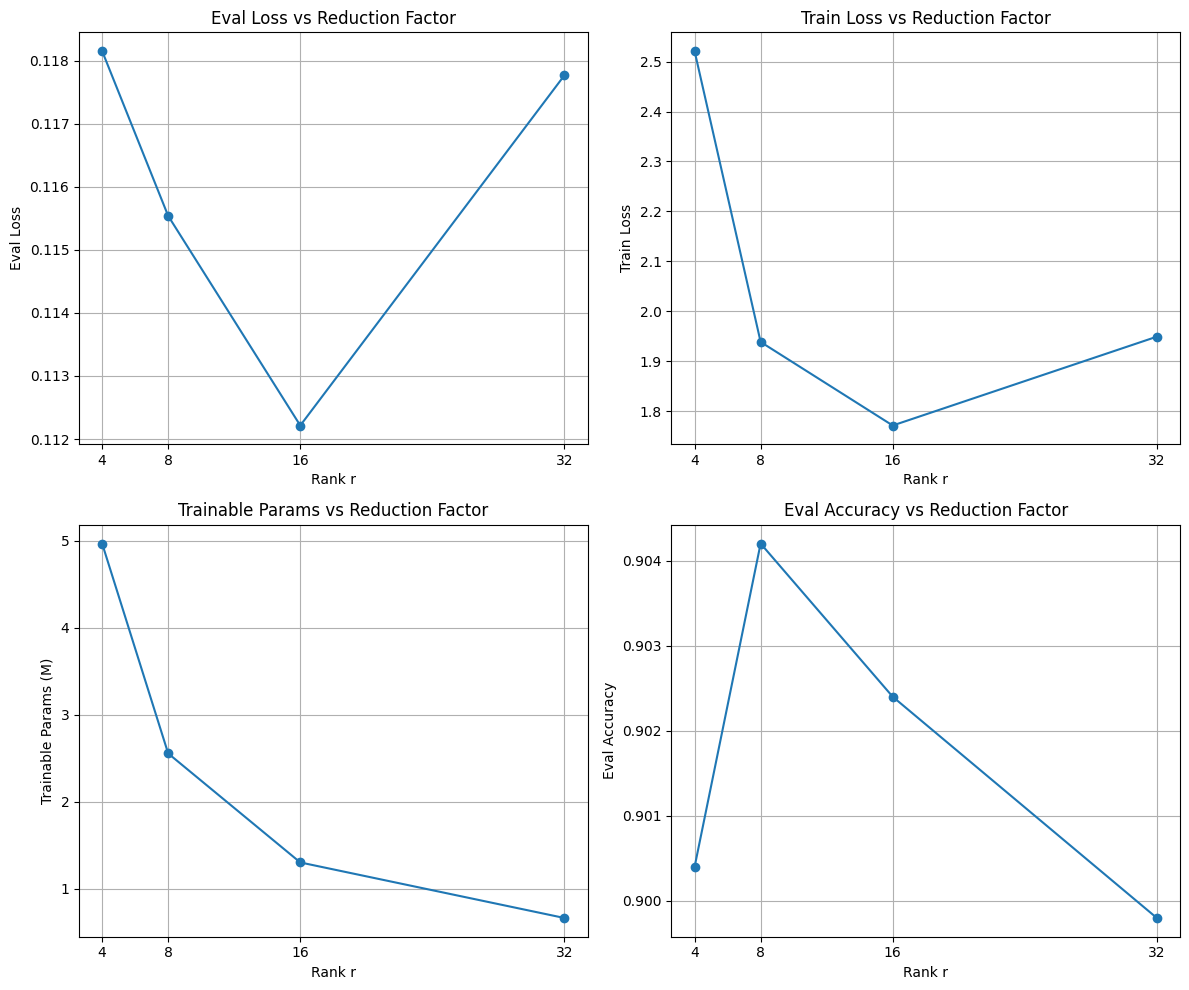

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

order = [4, 8, 16, 32]

results = pd.DataFrame(results)

# Ensure ordering
results["r"] = results["r"].astype(int)
results["r"] = pd.Categorical(results["r"], categories=order, ordered=True)
results = results.sort_values("r")

# --- 4 subplots in 2 × 2 layout ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top-left: Eval Loss
axes[0, 0].plot(results["r"], results["eval_loss"], marker="o")
axes[0, 0].set_title("Eval Loss vs Reduction Factor")
axes[0, 0].set_xlabel("Rank r")
axes[0, 0].set_ylabel("Eval Loss")
axes[0, 0].grid(True)
axes[0, 0].set_xticks(order)

# Top-right: Train Loss
axes[0, 1].plot(results["r"], results["train_loss"], marker="o")
axes[0, 1].set_title("Train Loss vs Reduction Factor")
axes[0, 1].set_xlabel("Rank r")
axes[0, 1].set_ylabel("Train Loss")
axes[0, 1].grid(True)
axes[0, 1].set_xticks(order)

# Bottom-left: Trainable Params
axes[1, 0].plot(results["r"], results["trainable_pct"], marker="o")
axes[1, 0].set_title("Trainable Params vs Reduction Factor")
axes[1, 0].set_xlabel("Rank r")
axes[1, 0].set_ylabel("Trainable Params (M)")
axes[1, 0].grid(True)
axes[1, 0].set_xticks(order)

# Bottom-right: Eval Accuracy
axes[1, 1].plot(results["r"], results["eval_acc"], marker="o")
axes[1, 1].set_title("Eval Accuracy vs Reduction Factor")
axes[1, 1].set_xlabel("Rank r")
axes[1, 1].set_ylabel("Eval Accuracy")
axes[1, 1].grid(True)
axes[1, 1].set_xticks(order)

plt.tight_layout()
plt.show()


### Observations
- Moderate adapter ranks (r = 8–16) offer the best trade-off between accuracy and trainable parameters.
- Very small adapter ranks (r = 4) underfit the task. r = 4 showed higher training loss and lower accuracy compared to r = 8 and r = 16. This indicates that the adapter bottleneck lacked sufficient capacity to capture sentiment-specific patterns in IMDB.


# Final Training and Evaluation (Reduction Factor r = 8)

After comparing multiple adapter configurations (r = 4, 8, 16, 32), we select **r = 8** as the final model configuration for the IMDB sentiment classification task.  


In [57]:
from datasets import concatenate_datasets

# merge training and validation splits for final training
full_train_ds = concatenate_datasets([train_ds, eval_ds])
test_ds = tokenized_ds["test"]


In [51]:
reduction_factor = 8

model = AutoAdapterModel.from_pretrained("t5-small")
adapter_config = AdapterConfig.load("houlsby", reduction_factor=reduction_factor)

adapter_name = f"imdb_adapter_r{reduction_factor}"
model.add_adapter(adapter_name, config=adapter_config)
model.train_adapter(adapter_name)
model.set_active_adapters(adapter_name)

data_collator.model = model


There are adapters available but none are activated for the forward pass.


In [60]:
print(model.adapter_summary())

Name                     Architecture         #Param      %Param  Active   Train
--------------------------------------------------------------------------------
imdb_adapter_r8          bottleneck        1,586,688       2.622       1       1
--------------------------------------------------------------------------------
Full model                                60,506,624     100.000               0


In [52]:
training_args = Seq2SeqTrainingArguments(
    output_dir=f"t5_adapter_final_r{reduction_factor}",
    eval_strategy="no",
    save_strategy="no",
    logging_steps=100,
    per_device_train_batch_size=128,
    gradient_accumulation_steps=4,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    per_device_eval_batch_size=4,
    fp16=True,
    logging_strategy="epoch",
    num_train_epochs=5,
    learning_rate=5e-3,
    weight_decay=0.01,
    predict_with_generate=True,
    report_to="none",
    gradient_checkpointing=True,
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=full_train_ds,
    eval_dataset=test_ds,  # this is fine because you're done selecting hyperparameters
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipykernel_96398/355461880.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [54]:
trainer.train()


/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
17,6.363900
34,0.634600
51,0.567500
68,0.516200
80,0.488900


TrainOutput(global_step=80, training_loss=1.7908026158809662, metrics={'train_runtime': 355.8183, 'train_samples_per_second': 351.303, 'train_steps_per_second': 0.225, 'total_flos': 1.6606073985171456e+16, 'train_loss': 1.7908026158809662, 'epoch': 4.7272727272727275})

In [58]:
final_results = trainer.evaluate(test_ds)
print(final_results)


/DATA405/khushi/peft/.venv_fresh/lib/python3.13/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.11444932967424393, 'eval_accuracy': 0.90988, 'eval_runtime': 426.4127, 'eval_samples_per_second': 58.629, 'eval_steps_per_second': 4.887, 'epoch': 4.7272727272727275}


In [59]:
model.save_adapter("adapter_r16", adapter_name)
trainer.save_model("t5_adapter_full_r16")


### Conclusion

Accuracy on test set : 90.1% using reduction factor = 8 which implies 2.622% trainable parameters